[0]	validation_0-rmse:44.31511	validation_1-rmse:33.54885
[100]	validation_0-rmse:26.91325	validation_1-rmse:23.76657
[200]	validation_0-rmse:20.78866	validation_1-rmse:21.47251
[300]	validation_0-rmse:17.80984	validation_1-rmse:20.68918
[400]	validation_0-rmse:16.01127	validation_1-rmse:20.20952
[500]	validation_0-rmse:14.80684	validation_1-rmse:19.96950
[600]	validation_0-rmse:13.89265	validation_1-rmse:19.83526
[700]	validation_0-rmse:13.02451	validation_1-rmse:19.77435
[780]	validation_0-rmse:12.44467	validation_1-rmse:19.77625
R^2: 0.4912
MAE: 14.92 gCO2/kWh


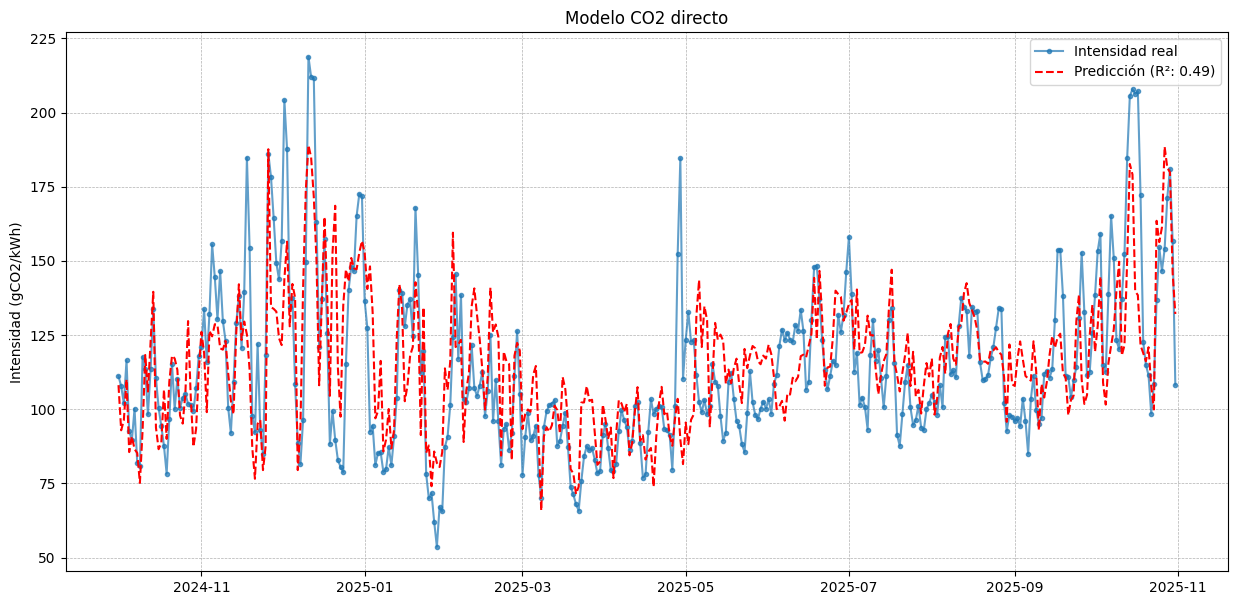

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import r2_score, mean_absolute_error
import matplotlib.pyplot as plt

DATA_PATH = '../data/2_processed/dataset_maestro_5min.parquet'
df_5min = pd.read_parquet(DATA_PATH)
df_5min = df_5min.sort_index()

emisiones_5min = (
    (df_5min['cc'] * df_5min['factorEmisionCO2_cc']) +
    (df_5min['car'] * df_5min['factorEmisionCO2_car']) +
    (df_5min['cogenResto'] * df_5min['factorEmisionCO2_cogenResto']) +
    (df_5min['die'] * df_5min['factorEmisionCO2_die']) +
    (df_5min['gas'] * df_5min['factorEmisionCO2_gas']) +
    (df_5min['vap'] * df_5min['factorEmisionCO2_vap'])
)

intensidad_5min = (emisiones_5min / df_5min['dem']) * 1000
df_5min['intensidad_g_kWh'] = intensidad_5min

agg_dict = {
    'intensidad_g_kWh': 'mean', 
    
    'temp_max_nacional_ponderada': 'first',
    'temp_min_nacional_ponderada': 'first',
    'viento_nacional_ponderado': 'first',
    'precipitacion_nacional_ponderada': 'first',
    
    'dia_año_sin': 'first',
    'dia_año_cos': 'first',
    'dia_semana_sin': 'first',
    'dia_semana_cos': 'first',
}
df_1d = df_5min.resample('D').agg(agg_dict)
df_1d = df_1d.rename(columns={'intensidad_g_kWh': 'intensidad_co2'})

H = 7
W = 28
col = 'intensidad_co2'
df_1d['lag_7d'] = df_1d[col].shift(H) 
df_1d['lag_14d'] = df_1d[col].shift(H * 2)
df_1d['mean_28d'] = df_1d[col].shift(H).rolling(window=W).mean()
df_1d['std_28d'] = df_1d[col].shift(H).rolling(window=W).std()
df_1d['lag_364d'] = df_1d[col].shift(364)

df_1d = df_1d.dropna() 

TARGET = 'intensidad_co2'
FEATURES = [
    'temp_max_nacional_ponderada',
    'temp_min_nacional_ponderada',
    'viento_nacional_ponderado',
    'precipitacion_nacional_ponderada',

    'dia_año_sin',
    'dia_año_cos',
    'dia_semana_sin',
    'dia_semana_cos',

    'lag_7d',
    'lag_14d',
    'mean_28d',
    'std_28d',
    'lag_364d'
]

X = df_1d[FEATURES]
y = df_1d[TARGET]

TEST_START_DATE_DIARIO = '2024-10-01'
X_train = X.loc[X.index < TEST_START_DATE_DIARIO]
y_train = y.loc[y.index < TEST_START_DATE_DIARIO]
X_test = X.loc[X.index >= TEST_START_DATE_DIARIO]
y_test = y.loc[y.index >= TEST_START_DATE_DIARIO]

model_final = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=4,
    objective='reg:squarederror',
    early_stopping_rounds=50,
    n_jobs=-1,
    random_state=42
)

model_final.fit(X_train, y_train,
                eval_set=[(X_train, y_train), (X_test, y_test)],
                verbose=100)

preds = model_final.predict(X_test)
r2_final = r2_score(y_test, preds)
mae_final = mean_absolute_error(y_test, preds)

print(f"R^2: {r2_final:.4f}")
print(f"MAE: {mae_final:.2f} gCO2/kWh")

plt.figure(figsize=(15, 7))
plt.plot(y_test.index, y_test, label='Intensidad real', 
         marker='.', alpha=0.7)
plt.plot(y_test.index, preds, 
         label=f'Predicción (R²: {r2_final:.2f})', 
         linestyle='--', color='red')
plt.title('Modelo CO2 directo')
plt.ylabel('Intensidad (gCO2/kWh)')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()